In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 5]

points=100
T_th = np.linspace(0.2,3.0,num=points)
beta = 1/T_th
J = 1.0
Ns = 50
th = np.tanh(J/T_th)
thN= th**Ns
ch = 1/th

# TODO sistemare parametri simulazione per avere fit migliore (test a basse temperature)!!

(21, 2)


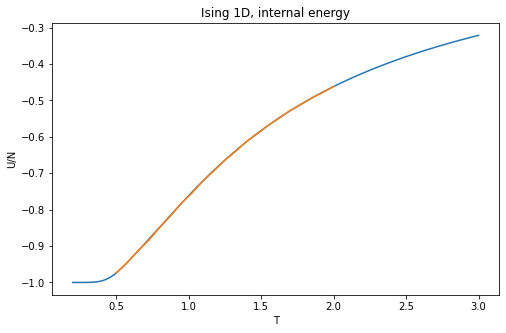

In [17]:
U_data = np.flipud(np.loadtxt("./ISING_1D/output.ene.0", delimiter=','))
U_data_final = []

for row in U_data:
    
    if row[0] == 20:
   
        U_data_final.append([row[2], row[3]])

U_data_final = np.asarray(U_data_final)
print(U_data_final.shape)

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)
e = -J*( th + ch*thN )/( 1 + thN )
plt.plot(T_th, e)
plt.title('Ising 1D, internal energy')
plt.xlabel('T')
plt.ylabel('U/N')

plt.errorbar(T, U_data_final[:, 0], yerr =  U_data_final[:, 1])
plt.show()

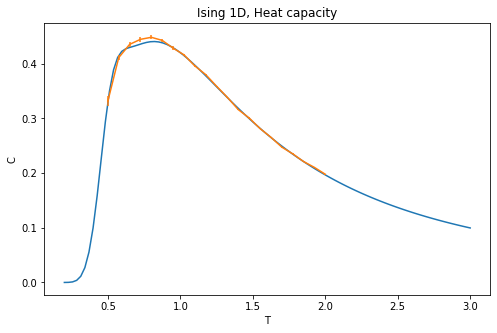

In [21]:
C_data = np.flipud(np.loadtxt("./ISING_1D/output.hec.0", delimiter=','))
C_data_final = []

for row in C_data:
    
    if row[0] == 20:
   
        C_data_final.append([row[2], row[3]])

C_data_final = np.asarray(C_data_final)

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)
C=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
plt.plot(T_th, C)
plt.title('Ising 1D, Heat capacity')
plt.xlabel('T')
plt.ylabel('C')

plt.errorbar(T, C_data_final[:, 0], yerr =  C_data_final[:, 1])
plt.show()

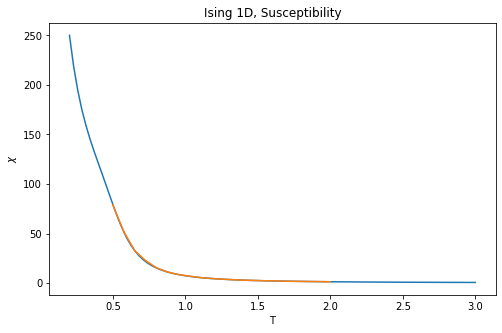

In [10]:
X_data = np.flipud(np.loadtxt("./ISING_1D/output.chi.0", delimiter = ','))
X_data_final = []

for row in X_data:
    
    if row[0] == 20:
   
        X_data_final.append([row[2], row[3]])

X_data_final = np.asarray(X_data_final)

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)

X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
plt.plot(T_th, X)
plt.title('Ising 1D, Susceptibility')
plt.xlabel('T')
plt.ylabel('$\chi$')
plt.errorbar(T, X_data_final[:, 0], yerr =  X_data_final[:, 1])
plt.show()

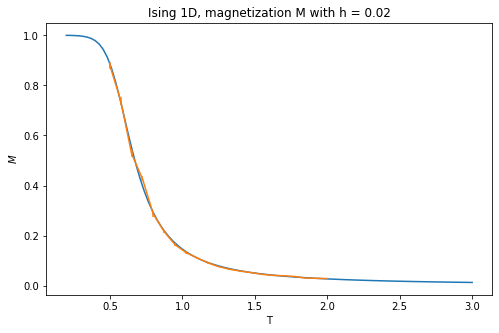

In [11]:
M_data = np.flipud(np.loadtxt("./ISING_1D/output.mag.0.02", delimiter = ','))
M_data_final = []

for row in M_data:
    
    if row[0] == 20:
   
        M_data_final.append([row[2], row[3]])

M_data_final = np.asarray(M_data_final)

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)

h=0.02 #external field
b = 1/T_th

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
plt.plot(T_th, M)
plt.title('Ising 1D, magnetization M with h = 0.02')
plt.xlabel('T')
plt.ylabel('$M$')
plt.errorbar(T, M_data_final[:, 0], yerr =  M_data_final[:, 1])
plt.show()

(21, 2)


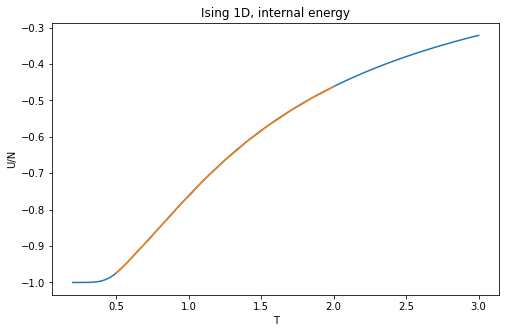

In [19]:
U_data = np.flipud(np.loadtxt("./ISING_1D/output.ene.0_g", delimiter=','))
U_data_final = []

for row in U_data:
    
    if row[0] == 20:
   
        U_data_final.append([row[2], row[3]])

U_data_final = np.asarray(U_data_final)
print(U_data_final.shape)

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)
e = -J*( th + ch*thN )/( 1 + thN )
plt.plot(T_th, e)
plt.title('Ising 1D, internal energy')
plt.xlabel('T')
plt.ylabel('U/N')

plt.errorbar(T, U_data_final[:, 0], yerr =  U_data_final[:, 1])
plt.show()

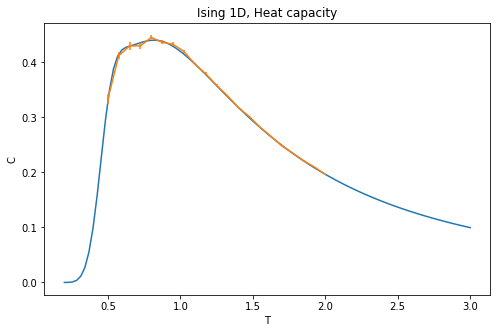

In [20]:
C_data = np.flipud(np.loadtxt("./ISING_1D/output.hec.0_g", delimiter=','))
C_data_final = []

for row in C_data:
    
    if row[0] == 20:
   
        C_data_final.append([row[2], row[3]])

C_data_final = np.asarray(C_data_final)

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)
C=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
plt.plot(T_th, C)
plt.title('Ising 1D, Heat capacity')
plt.xlabel('T')
plt.ylabel('C')

plt.errorbar(T, C_data_final[:, 0], yerr =  C_data_final[:, 1])
plt.show()

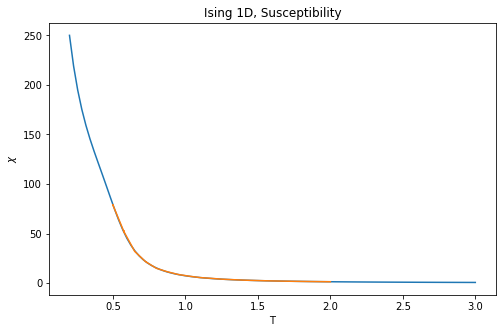

In [23]:
X_data = np.flipud(np.loadtxt("./ISING_1D/output.chi.0_g", delimiter = ','))
X_data_final = []

for row in X_data:
    
    if row[0] == 20:
   
        X_data_final.append([row[2], row[3]])

X_data_final = np.asarray(X_data_final)

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)

X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
plt.plot(T_th, X)
plt.title('Ising 1D, Susceptibility')
plt.xlabel('T')
plt.ylabel('$\chi$')
plt.errorbar(T, X_data_final[:, 0], yerr =  X_data_final[:, 1])
plt.show()

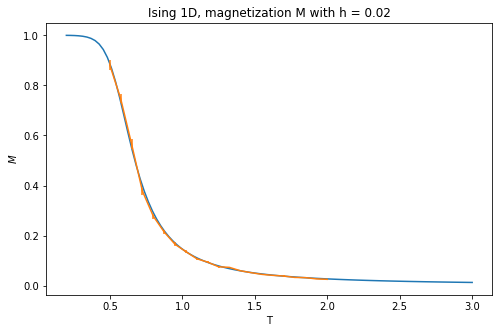

In [25]:
M_data = np.flipud(np.loadtxt("./ISING_1D/output.mag.0.02_g", delimiter = ','))
M_data_final = []

for row in M_data:
    
    if row[0] == 20:
   
        M_data_final.append([row[2], row[3]])

M_data_final = np.asarray(M_data_final)

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)

h=0.02 #external field
b = 1/T_th

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
plt.plot(T_th, M)
plt.title('Ising 1D, magnetization M with h = 0.02')
plt.xlabel('T')
plt.ylabel('$M$')
plt.errorbar(T, M_data_final[:, 0], yerr =  M_data_final[:, 1])
plt.show()